[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ran\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


数据基本信息：
                                               title  \
0              Kernelized Bayesian Transfer Learning   
1  "Source Free" Transfer Learning for Text Class...   
2  A Generalization of Probabilistic Serial to Ra...   
3         Lifetime Lexical Variation in Social Media   
4  Hybrid Singular Value Thresholding for Tensor ...   

                                             authors  \
0                  Mehmet Gönen and Adam A. Margolin   
1  Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...   
2                      Haris Aziz and Paul Stursberg   
3  Liao Lizi, Jing Jiang, Ying Ding, Heyan Huang ...   
4   Xiaoqin Zhang, Zhengyuan Zhou, Di Wang and Yi Ma   

                                              groups  \
0           Novel Machine Learning Algorithms (NMLA)   
1  AI and the Web (AIW)\nNovel Machine Learning A...   
2          Game Theory and Economic Paradigms (GTEP)   
3                        NLP and Text Mining (NLPTM)   
4  Knowledge Representation and Reason

C:\Users\Ran\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\cor

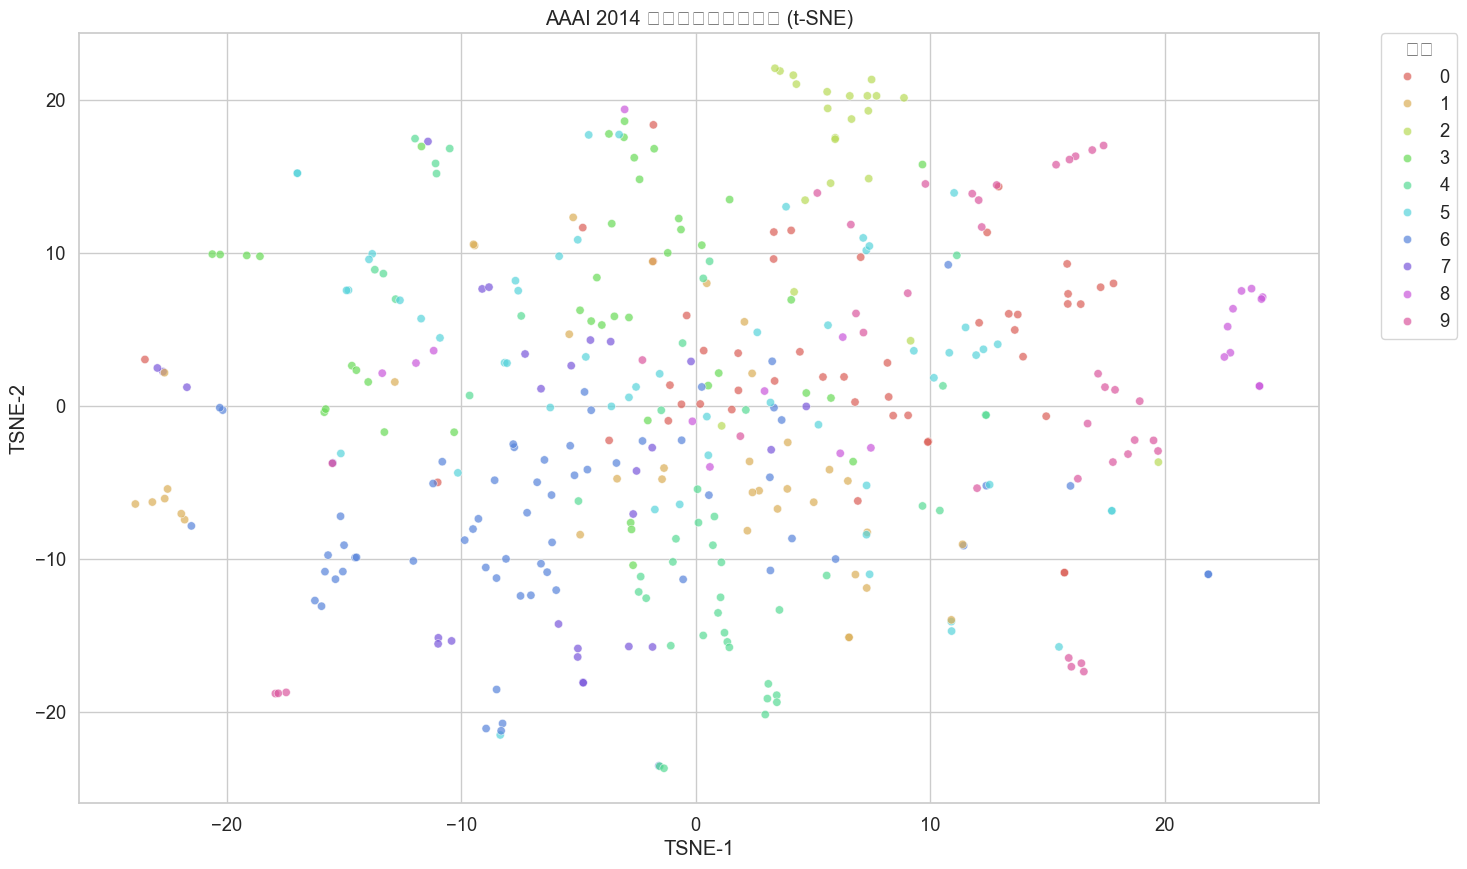


聚类结果已保存到 aaai2014_papers_clustered.csv


In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 用于文本预处理
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

# 用于特征提取和降维
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 用于聚类
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 下载NLTK的停用词
nltk.download('stopwords')

# 设置绘图风格
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# 1. 数据加载
data_path = '[UCI] AAAI-14 Accepted Papers - Papers.csv'  
df = pd.read_csv(data_path)

# 查看数据基本信息
print("数据基本信息：")
print(df.head())
print("\n数据维度：", df.shape)

# 2. 数据预处理
# 合并文本信息：标题、摘要和关键词
def combine_text(row):
    return ' '.join([
        str(row['title']) if not pd.isnull(row['title']) else '',
        str(row['abstract']) if not pd.isnull(row['abstract']) else '',
        str(row['keywords']) if not pd.isnull(row['keywords']) else ''
    ])

df['Text'] = df.apply(combine_text, axis=1)

# 文本清洗函数
def preprocess_text(text):
    # 转为小写
    text = text.lower()
    # 去除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 分词
    tokens = text.split()
    # 去除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # 词干提取
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# 应用文本预处理
print("\n正在进行文本预处理...")
df['Clean_Text'] = df['Text'].apply(preprocess_text)

# 3. 特征向量构造
# 使用TF-IDF向量化
print("正在进行TF-IDF向量化...")
vectorizer = TfidfVectorizer(max_features=5000)  # 可调整特征数量
X_tfidf = vectorizer.fit_transform(df['Clean_Text'])
print("TF-IDF特征维度：", X_tfidf.shape)

# 4. 聚类算法应用
# 选择聚类数量，例如10类
num_clusters = 10
print(f"\n正在进行K-Means聚类，聚类数目={num_clusters}...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_tfidf)
labels = kmeans.labels_

# 将聚类结果添加到数据框中
df['Cluster'] = labels

# 计算轮廓系数以评估聚类效果（可选）
sil_score = silhouette_score(X_tfidf, labels)
print(f"轮廓系数（Silhouette Score）：{sil_score:.4f}")

# 5. 观察每个聚类中的论文
print("\n每个聚类中的论文示例：")
for i in range(num_clusters):
    print(f"\n聚类 {i} 的前5篇论文标题：")
    cluster_titles = df[df['Cluster'] == i]['title'].head(5).values
    for title in cluster_titles:
        print(f"- {title}")

# 6. 可视化（降维后）
# 选择降维方法，例如PCA或t-SNE
print("\n正在进行降维和可视化...")
# 首先进行PCA降维到50维
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 然后使用t-SNE将数据降到2维
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# 将降维结果添加到数据框中
df['TSNE-1'] = X_tsne[:, 0]
df['TSNE-2'] = X_tsne[:, 1]

# 绘制散点图
plt.figure(figsize=(16, 10))
palette = sns.color_palette('hls', num_clusters)
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Cluster',
    palette=palette,
    data=df,
    legend='full',
    alpha=0.7
)
plt.title('AAAI 2014 论文聚类结果可视化 (t-SNE)')
plt.legend(title='聚类', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# 可选：保存聚类结果
output_path = 'aaai2014_papers_clustered.csv'
df.to_csv(output_path, index=False)
print(f"\n聚类结果已保存到 {output_path}")
